# **Tutorial 1: Modelling Heat Transfer in Buildings**

## Overview

In this tutorial, we estimate data-driven heat transfer models for a building envelope. We use real-world measurement data from an occupied, semi-detached house in the UK [1], which was retrofit in Spring/Summer 2016 and occupied in September 2016. The data set is publicly available [here](https://discovery.ucl.ac.uk/id/eprint/10087216/) and comprises two 5-day periods of measurements at a 10-minute resolution.

By the end of this tutorial, you should be able to:
- Process and interpret building measurement data.
- Formulate data-driven (grey- and black-box) models for building heat transfer.
- Compare and validate different modelling approaches using good-of-fit and statistical metrics.

[1] Hollick, F; Wingfield, J; (2018) Two periods of in-situ measurements from an occupied, semi-detached house in the UK [Dataset]. 10.14324/000.ds.10087216.

## Set up

Load the necessary Python libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import lsq_linear

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (10,4)

## Data processing

We first load and visualize the data. First, set up the ```data_path``` variable to the correct file location and load the data set. The data set spans two 5-day periods. The data from the first period (November 2016) is considered first.

In [2]:
#%% Load measurement data

data_path = 'C:\\Users\\ucbva19\\Git projects\\BENV0092\\data'
data = pd.read_csv(f'{data_path}\\10mins_solpap_2016.csv', index_col = 0)
data.index = pd.to_datetime(data.index, format="%d/%m/%Y %H:%M")

### Preliminary analysis

The first task is to familiarize ourselves with the data and assess its quality. To familiarize with the data, we can generate plots, provide summary statistics, and estimate correlations/ autocorrelations.

**Discussion**:
- Interpret parameters and estimate some summary statistics.
- Describe some salient characteristics of the ```P_tot (W)``` variable.

                     T_Bath (degC)  T_Bed1 (degC)  T_Bed2 (degC)  El_use (W)  \
Date and time                                                                  
2016-11-11 00:00:00           19.9           17.0           17.2         528   
2016-11-11 00:10:00           20.0           17.1           17.1         288   
2016-11-11 00:20:00           20.0           17.1           17.2         354   
2016-11-11 00:30:00           20.0           17.2           17.3         222   
2016-11-11 00:40:00           20.1           17.3           17.4         396   

                     T_External (degC)  Gas (W)  T_Kitchen (degC)  \
Date and time                                                       
2016-11-11 00:00:00                5.0  6817.60              19.3   
2016-11-11 00:10:00                5.2  4090.56              19.2   
2016-11-11 00:20:00                5.2   681.76              19.2   
2016-11-11 00:30:00                5.2  7499.36              19.2   
2016-11-11 00:40:00      

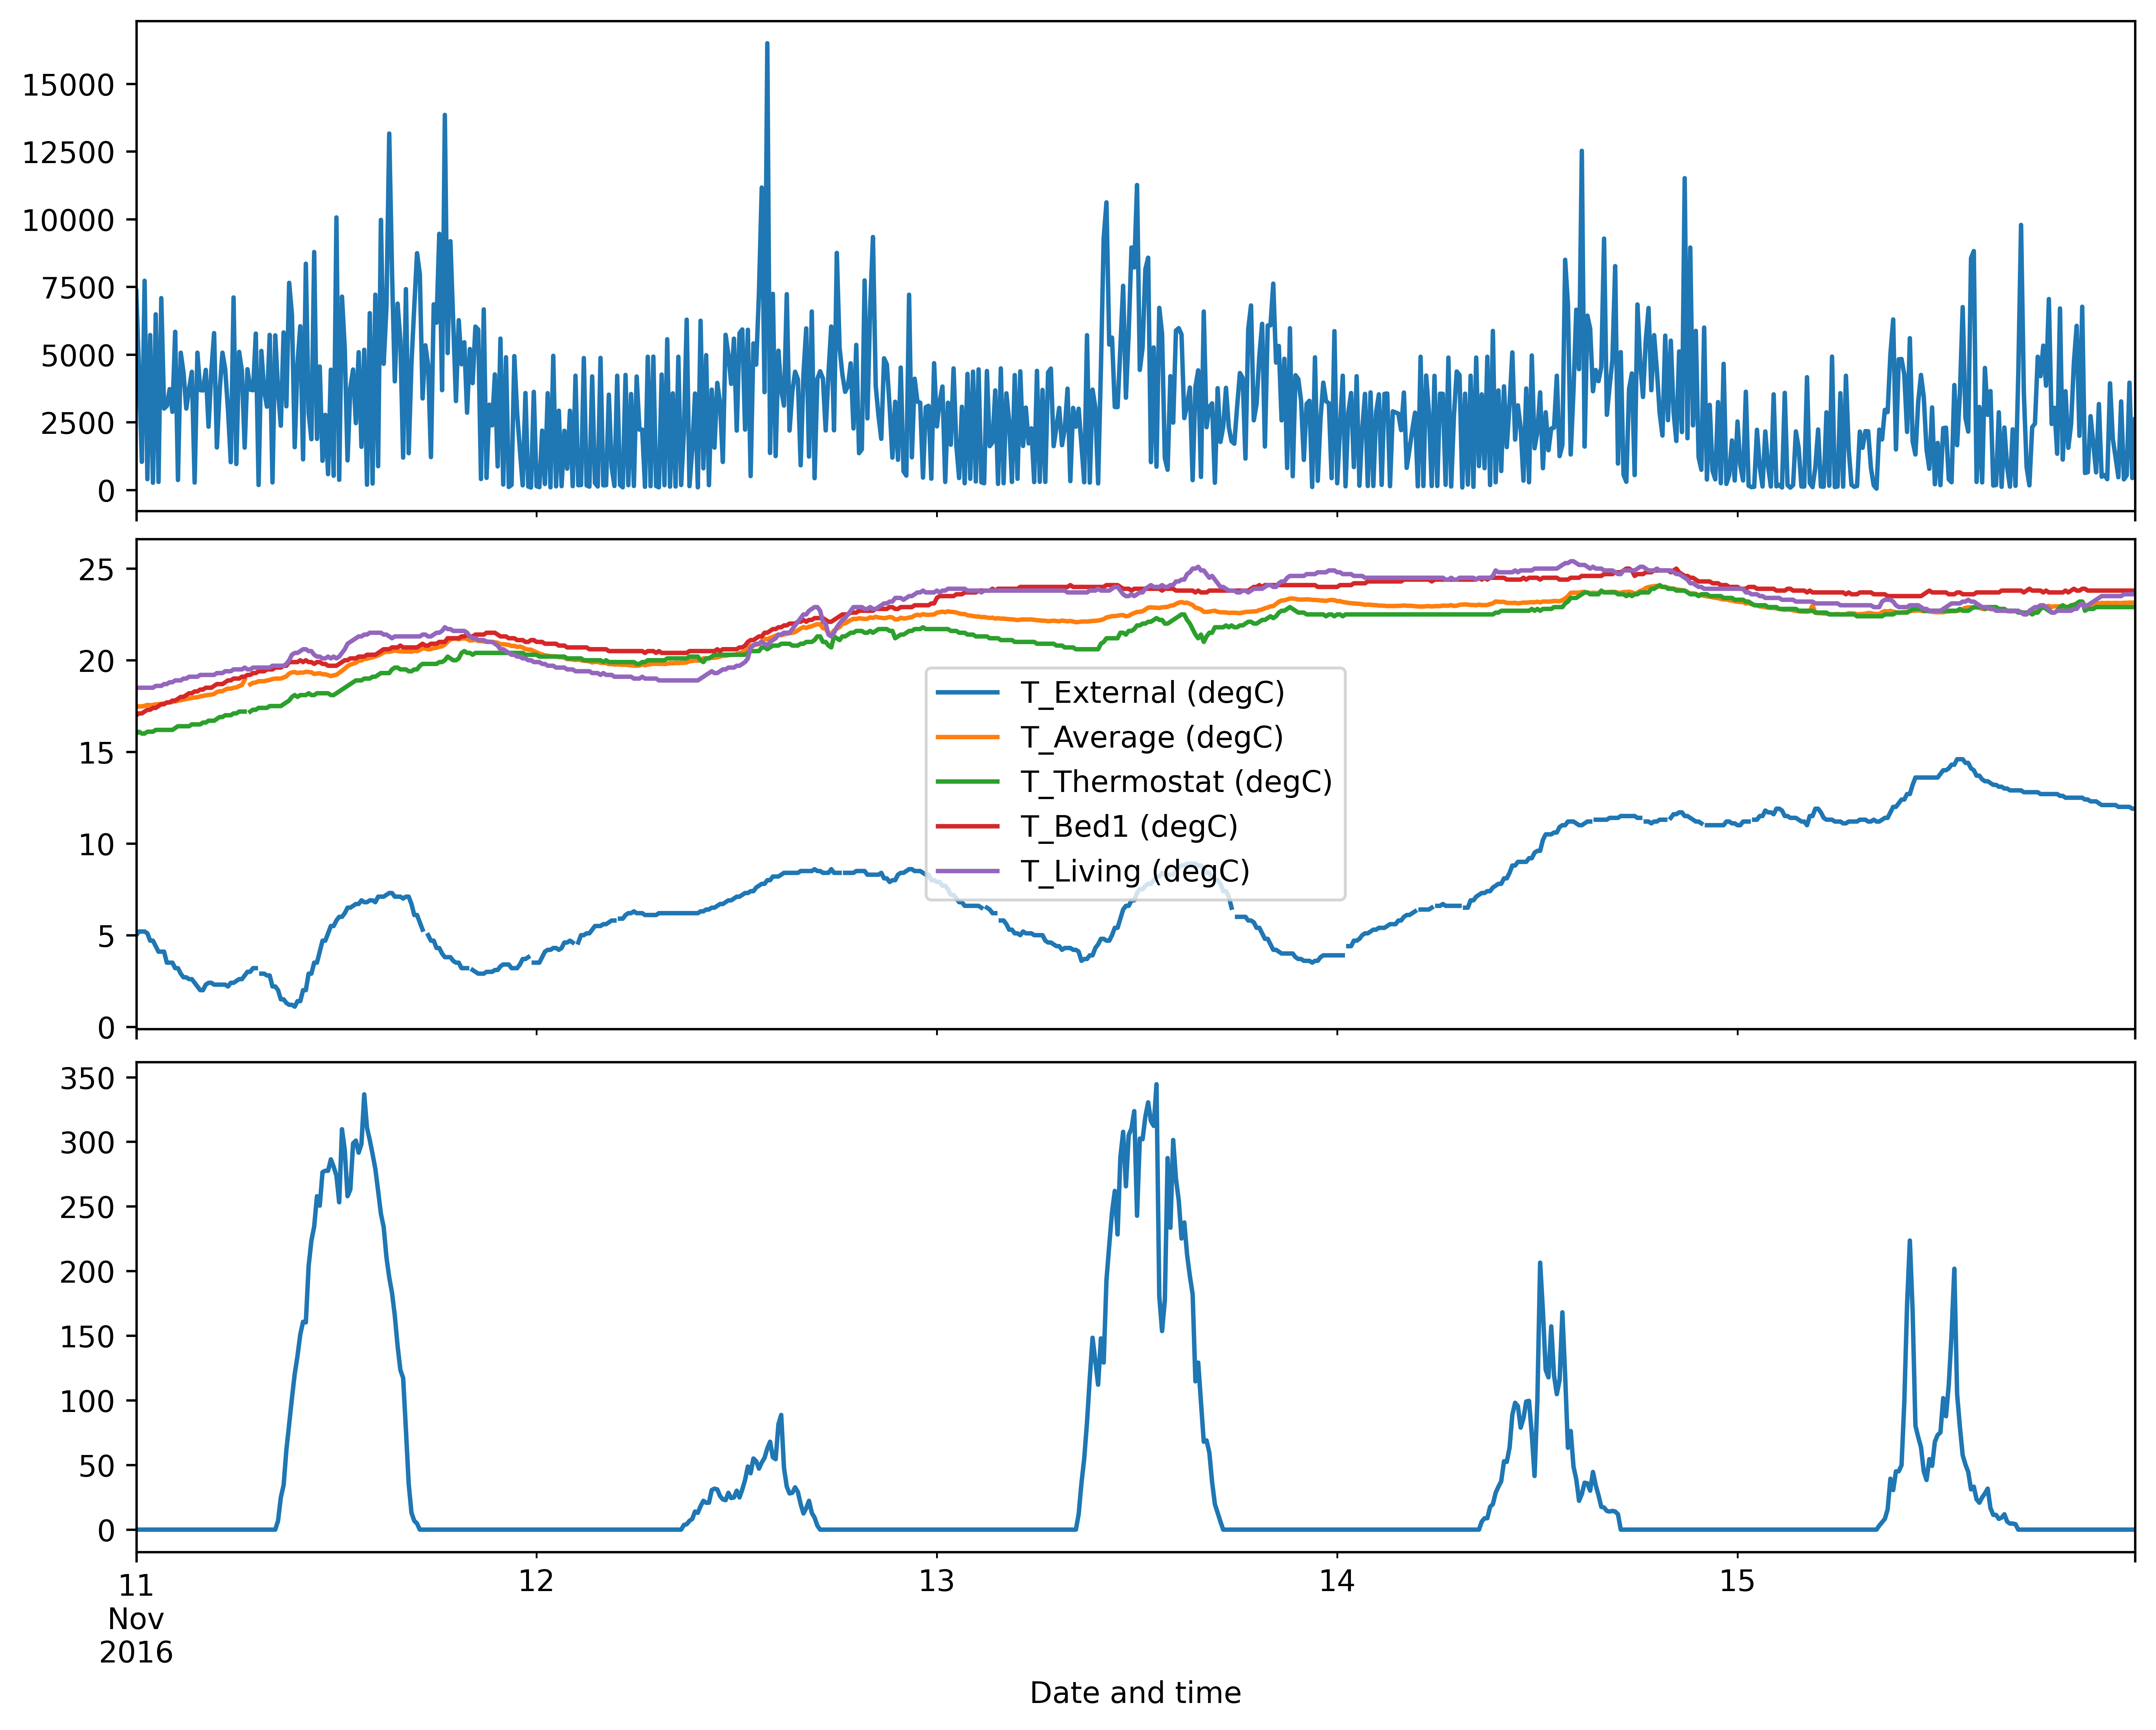

In [3]:
print(data.head())
print(f'Percentage of missing observations: {100*data.isna().sum()/len(data)}')

# Visualization 
fig, ax = plt.subplots(figsize=(10,8), nrows = 3, sharex = True)

data['P_tot (W)'].plot(ax=ax[0])
data[['T_External (degC)', 'T_Average (degC)', 'T_Thermostat (degC)', 'T_Bed1 (degC)', 'T_Living (degC)']].plot(ax=ax[1])
data['Solar (W/m2)'].plot(ax = ax[2])
plt.show()

### Dealing with missing data

Some variables contain missing data. A good practice is to visually examine the missing data and then pick an appropriate imputation method. Considering that we are dealing with 10-minute time series data, a simple linear interpolation seems sensible. 

**Discussion**:
- Consider the most common imputation method, i.e., replacing with the mean value. Is this a good approach here?

In [4]:
# Fill missing data with linear interpolation
data = data.interpolate('linear')
assert(data.isna().all().sum() == 0)


## Modelling heat transfer

We will formulate different data-driven models for the envelope heat transfer model. The following assumptions are in place:
- We consider a single-zone model and use the average room temperature, ```T_Average (degC)```, as a proxy.
- We consider a 10-minute discretization step, i.e., $dt=1/6$, which is the same as the data granularity.
- We use the total power, ```P_tot (W)```, as a proxy for the net heat injection, which is a simplification. Ideally, we would like to include potential losses. This means that we need to be careful with the physical interpretation of the estimated parameters.

To streamline the code, we introduce auxiliary variables and set up parameters.

In [5]:
# Lead T_in values (target variable)
data['T_Average_lead_1'] = data['T_Average (degC)'].shift(-1)
data['T_diff'] = data['T_External (degC)'] - data['T_Average (degC)']

# Drop NaNs created from the shift operator
data = data.dropna()

# discretization step at 10 minutes
dt_h = 1/6

### Deriving the $RC$ model

We consider a simple $1R-1C$ model to approximate the heat transfer dynamical model of a single-zone dwelling.:

- $R_{\text{th}}$ = thermal resistance (°C/kW)  
- $C_{\text{th}}$ = thermal capacitance (kWh/°C)
- $\tau = R_{\text{th}} C_{\text{th}}$ = time constant

The continuous-time energy balance is given by

<center>$ C_{\text{th}} \frac{dT}{dt} = \frac{T_\text{ext} - T}{R_{\text{th}}} + H_\text{heat} + g H_\text{solar}$,</center>


where $T$ is the average indoor temperature (°C), $T_\text{ext}$ is the external temperature (°C), and $H_\text{heat}$ is the sensible heat injection in the node (kW), $H_\text{solar}$ is the solar radiation, and $g$ is the (unknown) solar gain factor.

Equivalently, we can write 
<center>$ \frac{dT}{dt} =
\frac{1}{\tau}(T_\text{ext} - T)
+ \frac{1}{C_{\text{th}}}H_{\text{heat}} + \frac{g}{C_{\text{th}}}H_{\text{solar}}$.</center>

Using forward Euler discretization, we get
<center>
$
T_{k+1}
=
T_k
+ \Delta t \frac{1}{\tau}(T_{\text{ext},k} - T_k)
+ \Delta t \frac{1}{C_{\text{th}}} H_{\text{heat},k} + \Delta t \frac{g}{C_{\text{th}}} H_{\text{solar},k},
$    
</center>


where $k$ is the time step index. For convenience, we define the **discrete coefficients**:

<center>
$
\alpha_1 = \frac{\Delta t}{\tau}, \qquad
\alpha_2 = \frac{\Delta t}{C_{\text{th}}}, \qquad,
\alpha_3 = \frac{\Delta t g}{C_{\text{th}}}.
$    
</center>

The final discrete $RC$ model is given by

<center>
$
T_{k+1} = T_k + \alpha_1 (T_{\text{out},k} - T_k)
+ \alpha_2 H_{\text{heat},k} + \alpha_3 H_{\text{solar},k}.$
</center>


### $RC$ parameter estimation

Next, we estimate the parameters of the $RC$ model, or, equivalently, coefficients $\alpha_{1,2,3}$. Throughout, we use $\hat{\cdot}$ to denote parameters estimated (i.e., learned) from data. First, for the $k$th observation, we define the loss function

<center>
$\ell(\hat{T}_k, T_{k})=(\hat{T}_k-T_{k})^2 = \bigl(T_k + \alpha_1(T_{\text{out},k} - T_k)
+ \alpha_2 H_{\text{heat},k} + \alpha_3 H_{\text{solar},k} - T_{k+1}\bigr)^2$,
</center> 

which represents the mean squared error (MSE) between predicted temperature $\hat{T}$ and actual temperature $T$.
To estimate the parameters, we minimize the empirical mean squared error over the training data set which contains $N$ observations, 
given by

<center>
$\min_{\alpha_{1,2,3}} \sum_{k=1}^{N-1} \ell(\hat{T}_k, T_{k})$,    
</center>
 
which defines a constrained regression problem.

**Excercise**: Your task is to solve the constrained optimization problem described above and return the $RC$ parameters. 

*Hint*: You can use the ```cvxpy``` library to formulate and solve a constrained optimization problem. The ```lsq_linear``` function can also be used to solve a constrained linear least squares problem.


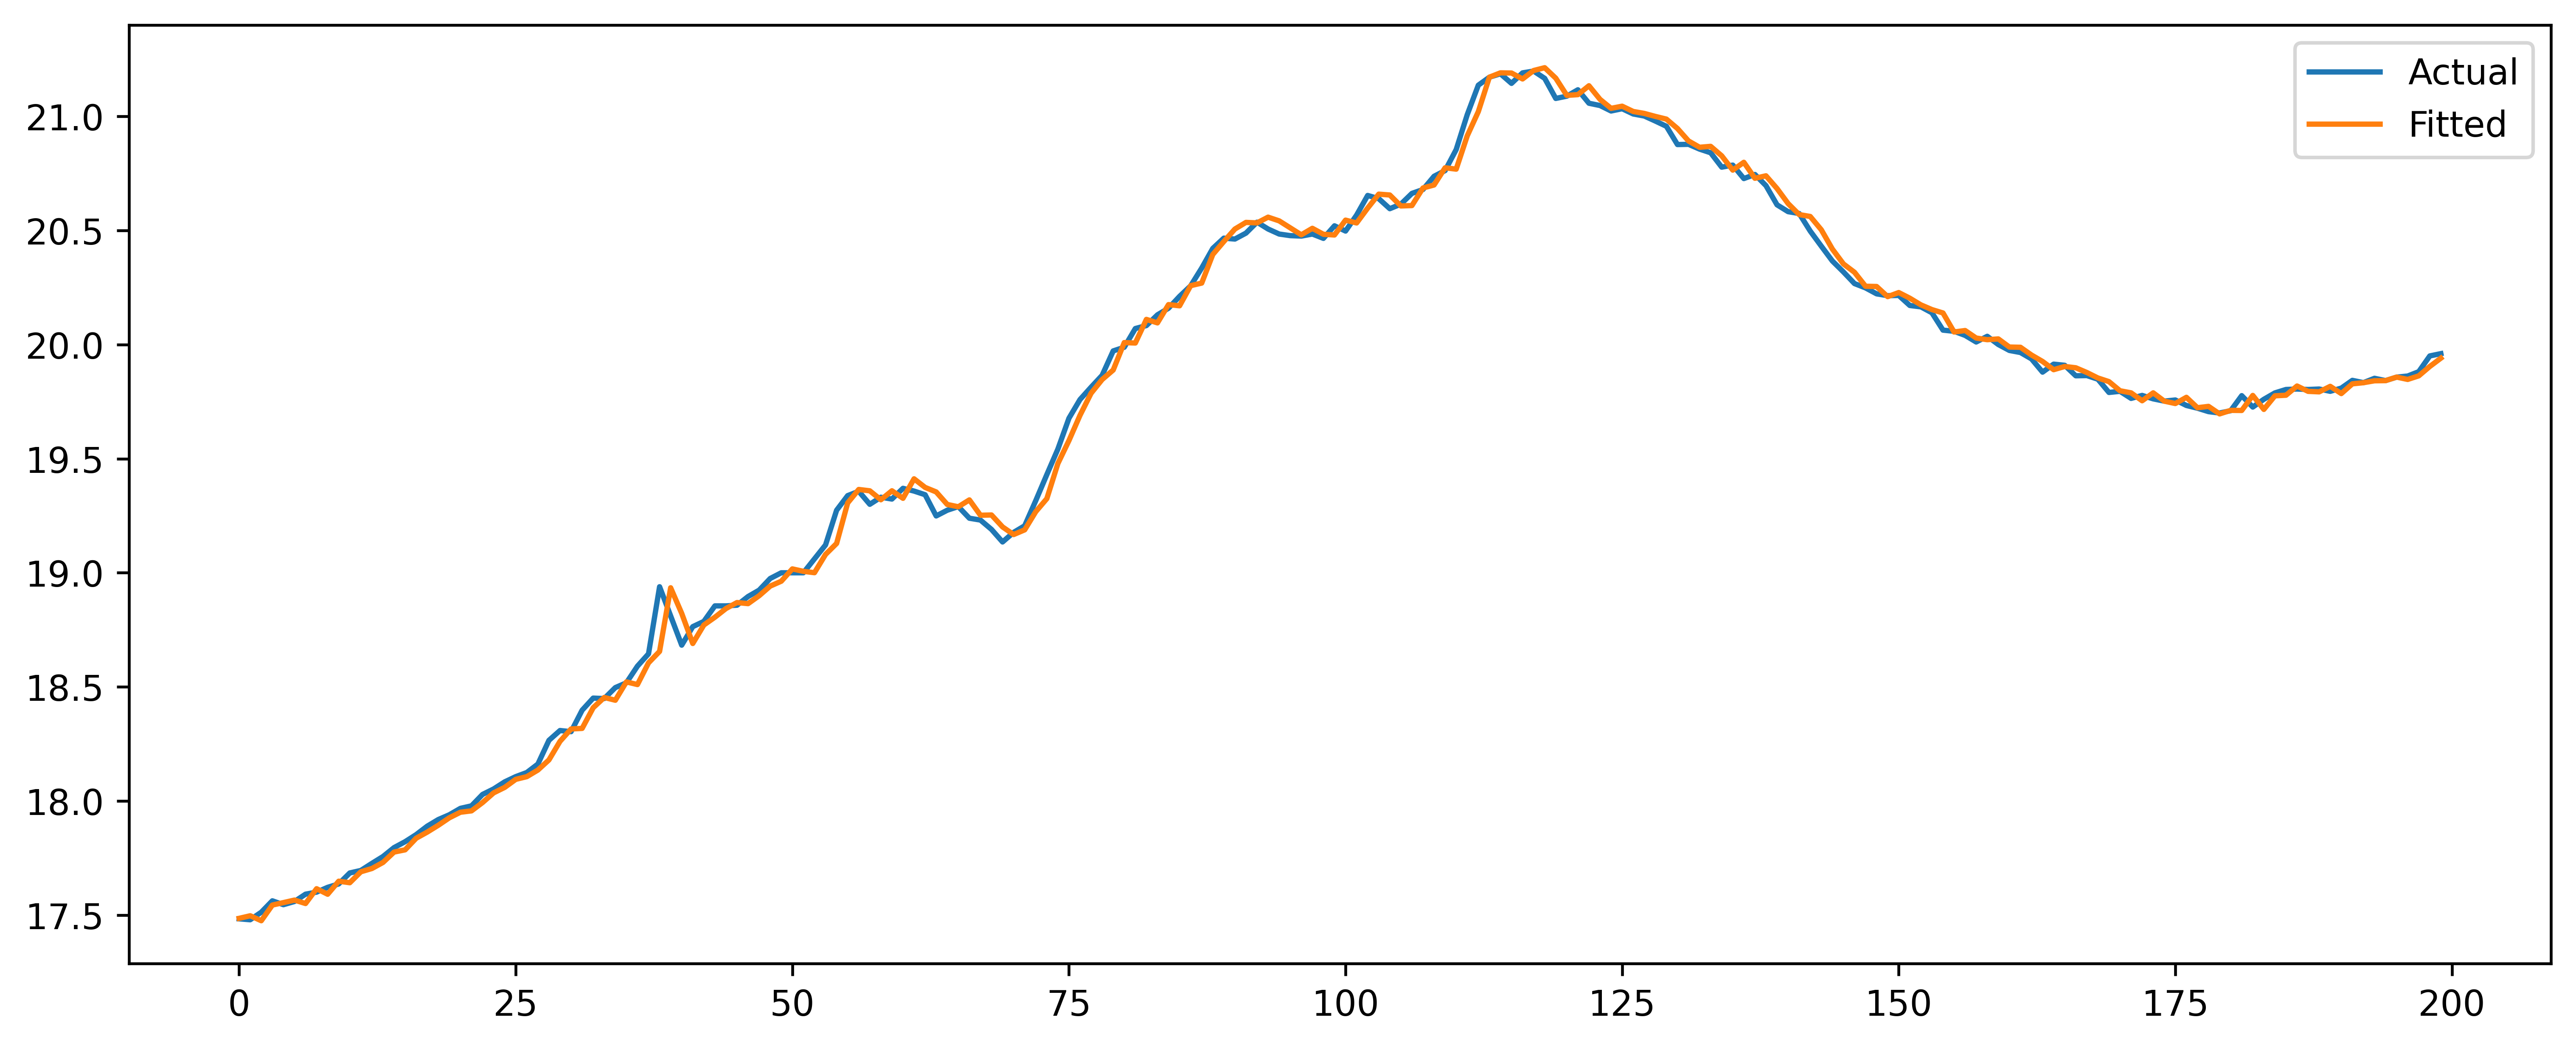

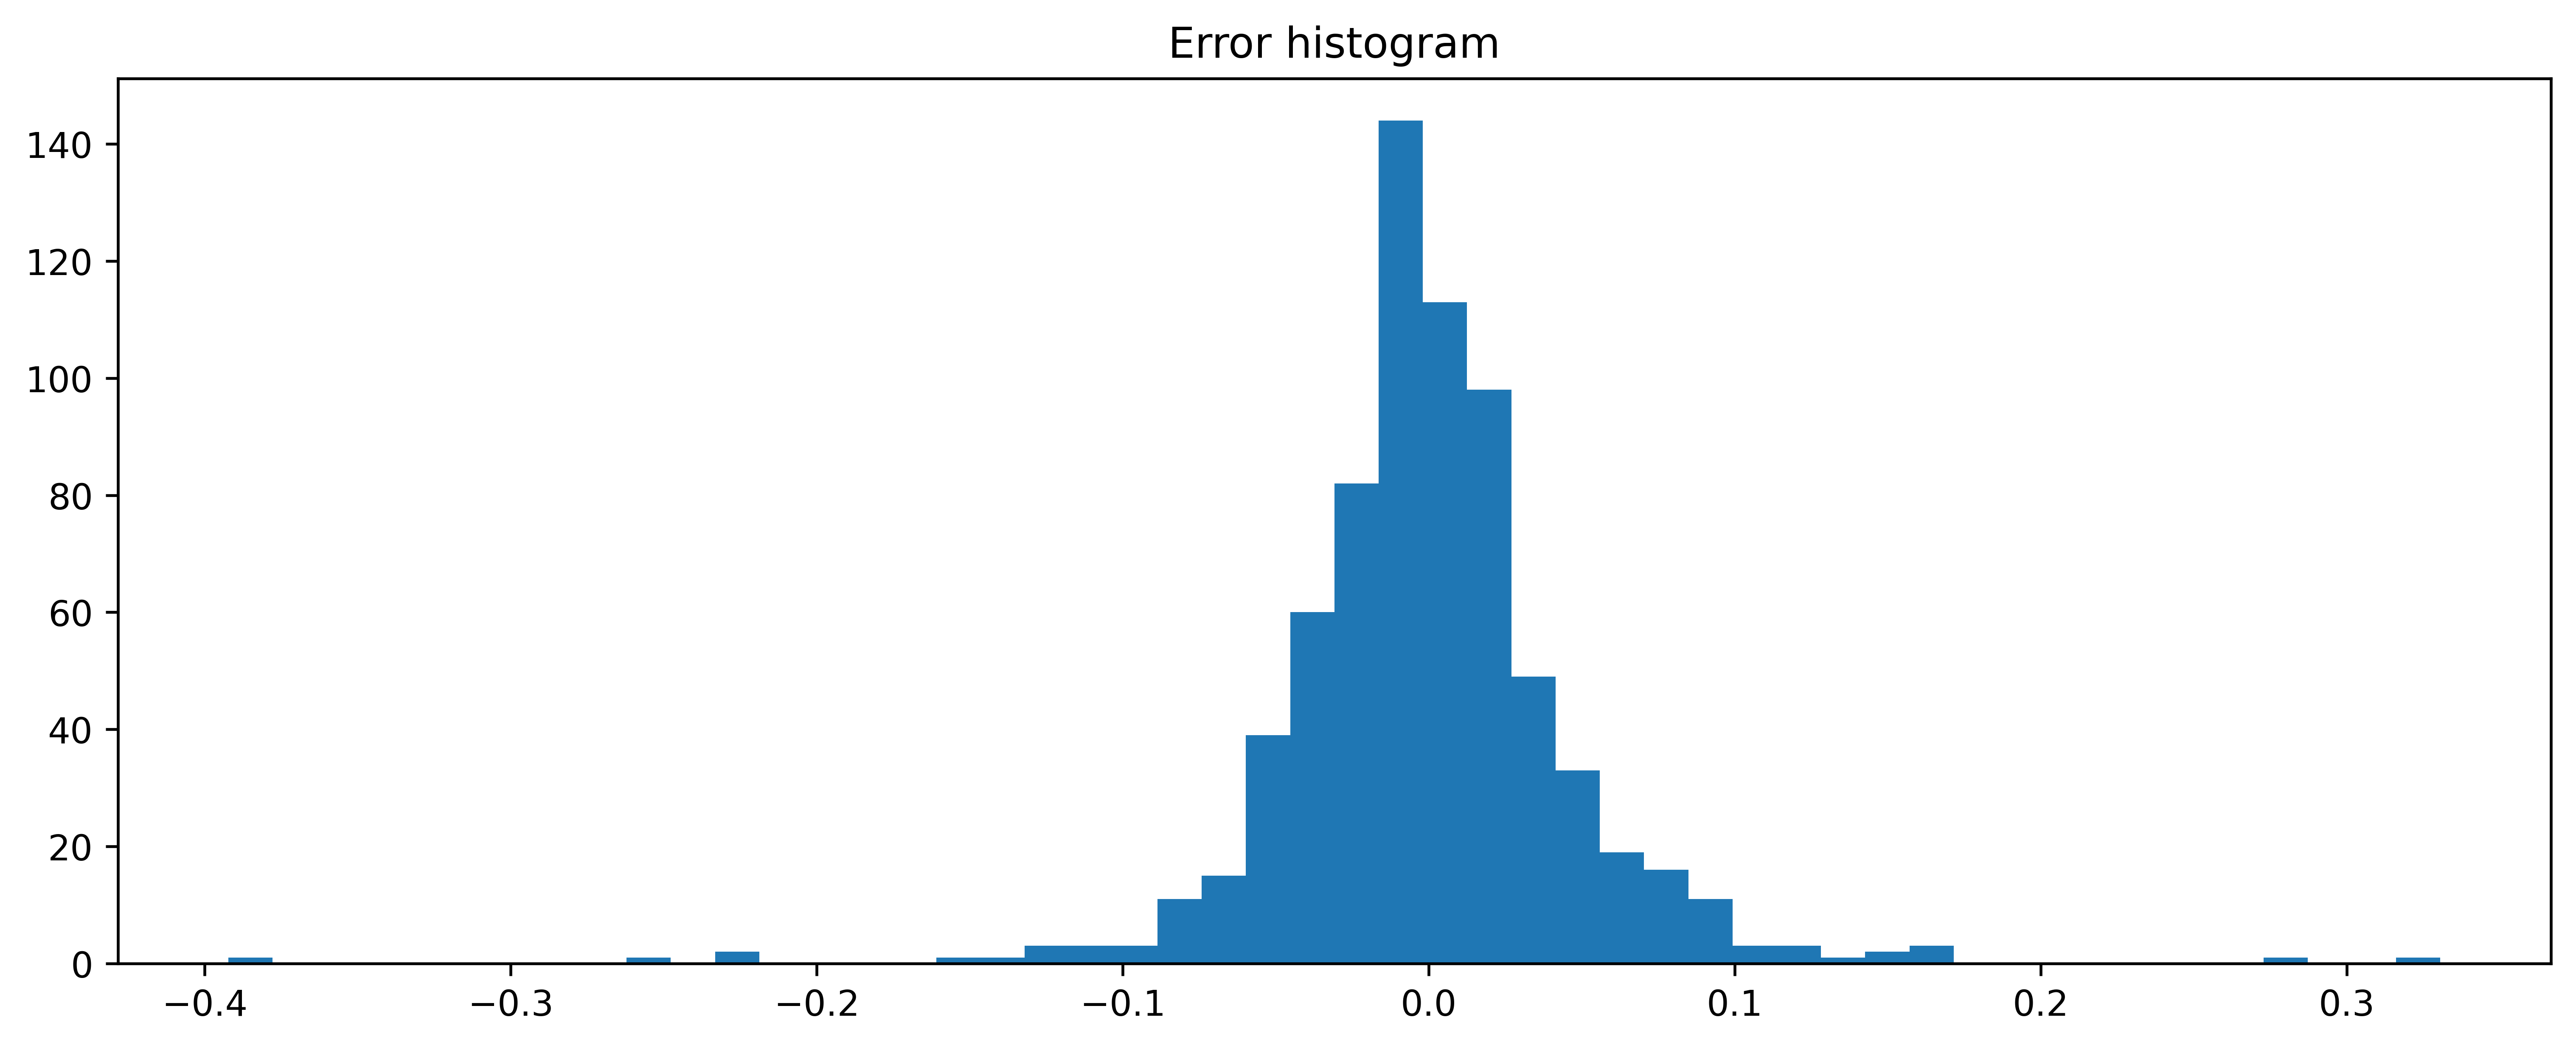

In-sample RMSE
0.048801249459685246
RC parameters
tau:211.98300966928915
C:31271.19333902009
R:0.006778858976410646
g:12.887422028586613


In [6]:
#%% Find parameters for lumped RC model

Y = data['T_Average_lead_1']
X = data[['T_diff', 'P_tot (W)', 'Solar (W/m2)', 'T_Average (degC)']]

# Solve a least-squares optimization problem to estimate RC parameters
A = X.values
b = Y.values

lsq_solution = lsq_linear(A, b, bounds = ([-np.inf, -np.inf, -np.inf, 1-1e-5], [np.inf, np.inf, np.inf, 1]) )

x_coeff = lsq_solution.x

alpha_1 = x_coeff[0]
alpha_2 = x_coeff[1]
alpha_3 = x_coeff[2]

tau = dt_h/alpha_1
C = dt_h/alpha_2
R = tau/C
g = alpha_3/alpha_2

T_fitted = x_coeff@A.T
fit_errors = b - x_coeff@A.T


plt.plot(b[:200], label = 'Actual')
plt.plot(x_coeff@A[:200].T, label = 'Fitted')
plt.legend()
plt.show()

plt.hist(fit_errors, bins = 50, label = 'Errors')
plt.title('Error histogram')
plt.show()

print('In-sample RMSE')
print( np.sqrt(np.square(b - x_coeff@A.T).mean()) )

print('RC parameters')
print(f'tau:{tau}')
print(f'C:{C}')
print(f'R:{R}')
print(f'g:{g}')

### Linear regression

We now model the heat transfer as an (unconstrained) linear regression given by $f(x;\theta) = \theta^\top x$, where $x$ concats all the features used (```['T_diff', 'P_tot (W)', 'Solar (W/m2)', 'T_Average (degC)']```) and $\theta$ are the coefficients. To train the linear regression (i.e., to learn parameters $\theta$) we need to solve

<center>
$\min_{\theta} \sum_{k=1}^{N-1} \ell(f(x;\theta), T_{k})$,    
</center>

which is a standard least squares regression.  

In [7]:
# Redefine feature vector
Y = data['T_Average_lead_1']
X = data[['T_diff', 'P_tot (W)', 'Solar (W/m2)', 'T_Average (degC)']]

lr = LinearRegression(fit_intercept = False).fit(X, Y)

print('In-sample RMSE')
print( np.sqrt(np.square(Y - lr.predict(X)).mean()) )

tau = dt_h/lr.coef_[0]
C = dt_h/lr.coef_[1]
R = tau/C

print('RC parameters')
print(f'tau:{tau}')
print(f'C:{C}')
print(f'R:{R}')

In-sample RMSE
0.04870256377902633
RC parameters
tau:-861.5848416467579
C:30458.261907760792
R:-0.028287393556991686


**Discussion**:
- Which model has the lowest RMSE? Could you have guessed it beforehand?
- Try to interpret RC parameters from unconstrained linear regression model. What happens? Do the values make sense?

**Additional exercises**:
- Estimate $R^2$ and other goodness-of-fit measures.
- Fit a nonlinear machine learning model, e.g., random forecasts, gradient boosting.
- Add more features.

## Repeating the experiment using June 2017 data

Previous experiment used data from November 2016. We repeat the experiment using measurement data from June 2017. 

**Discussion:**
- What do you observe? How are the estimated parameters affected? Is the fit better or worse?

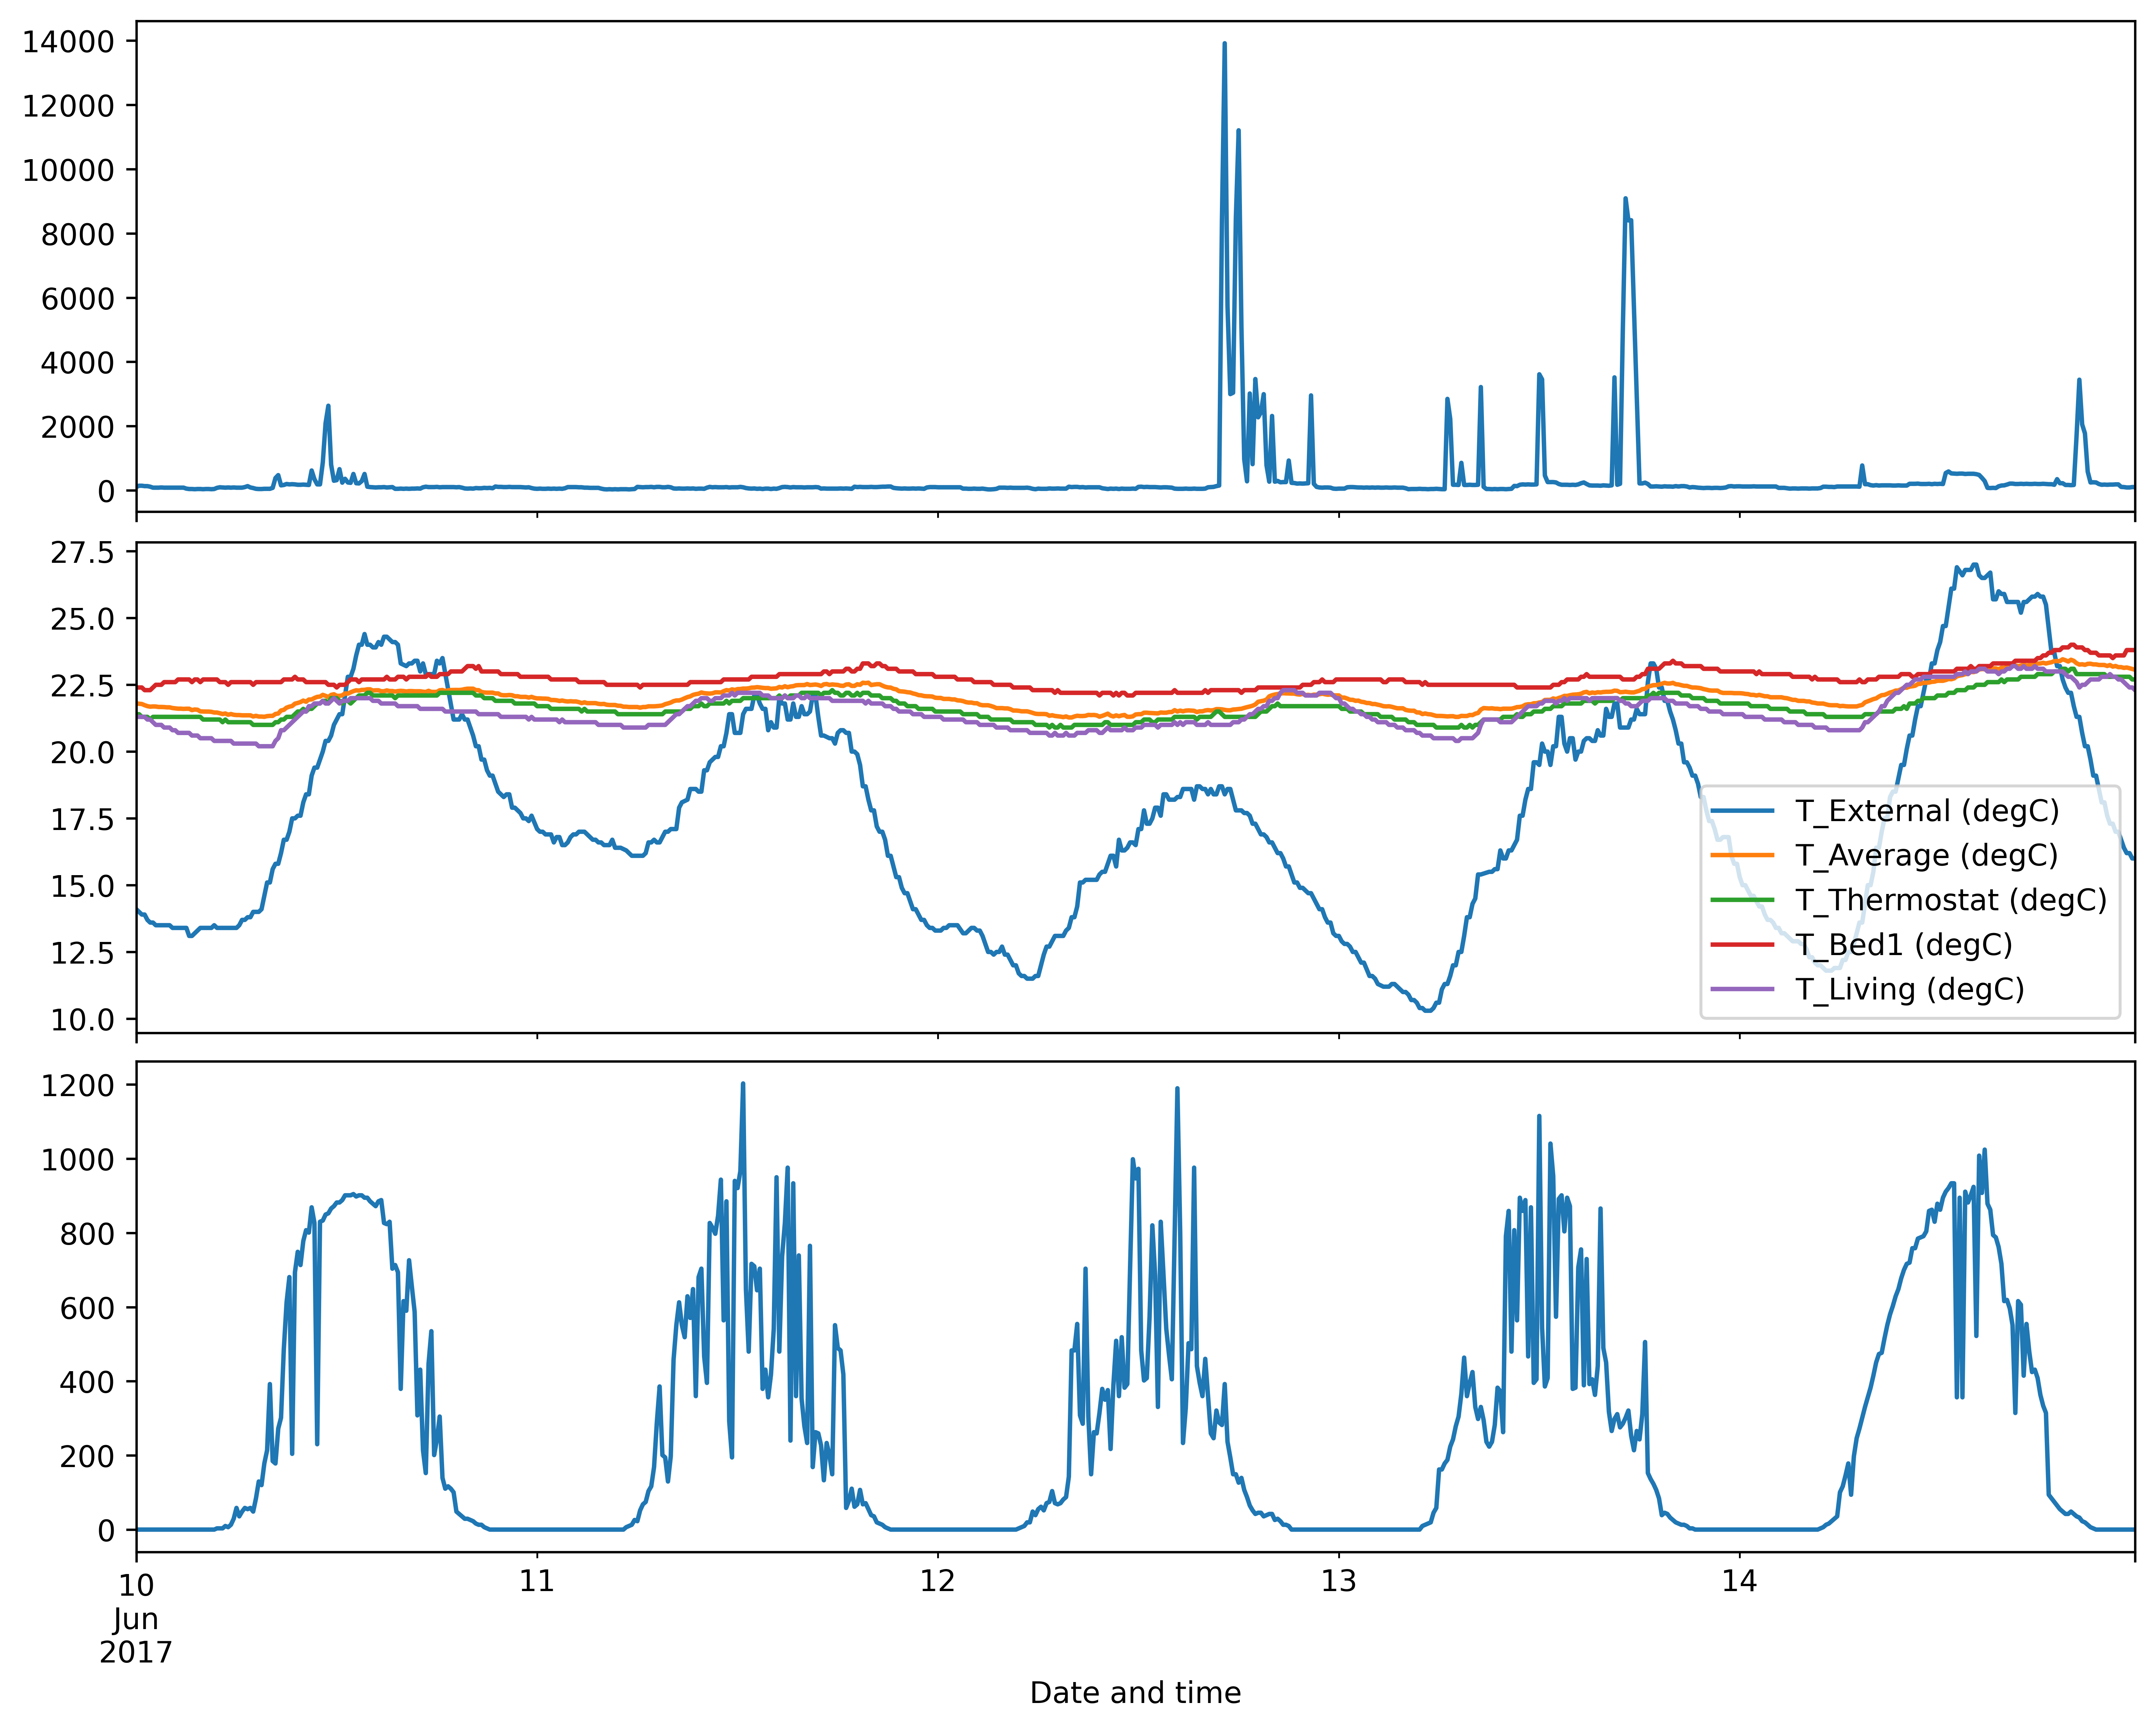

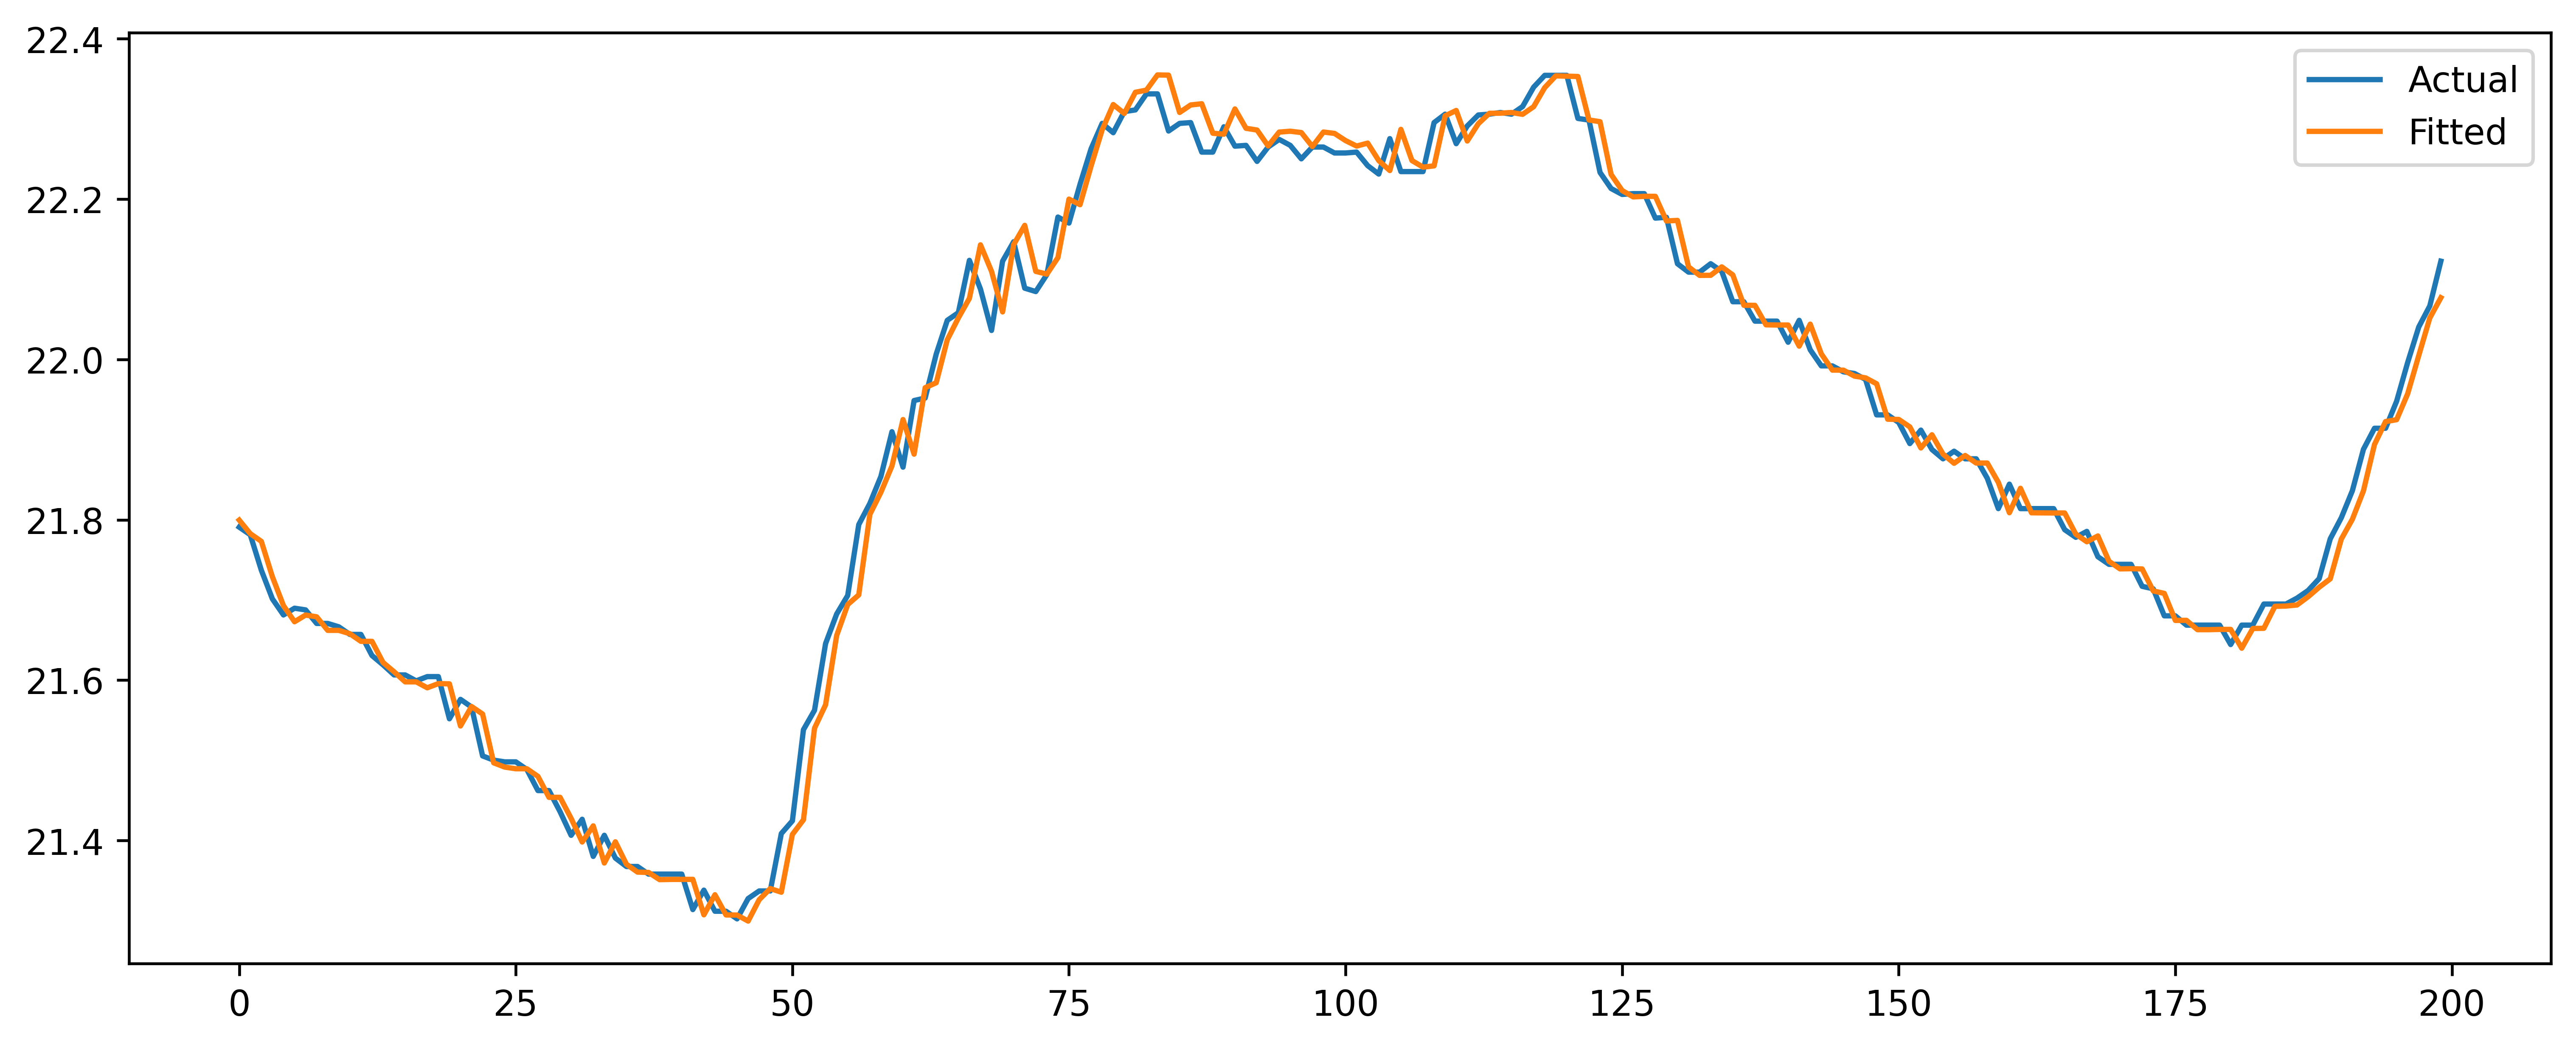

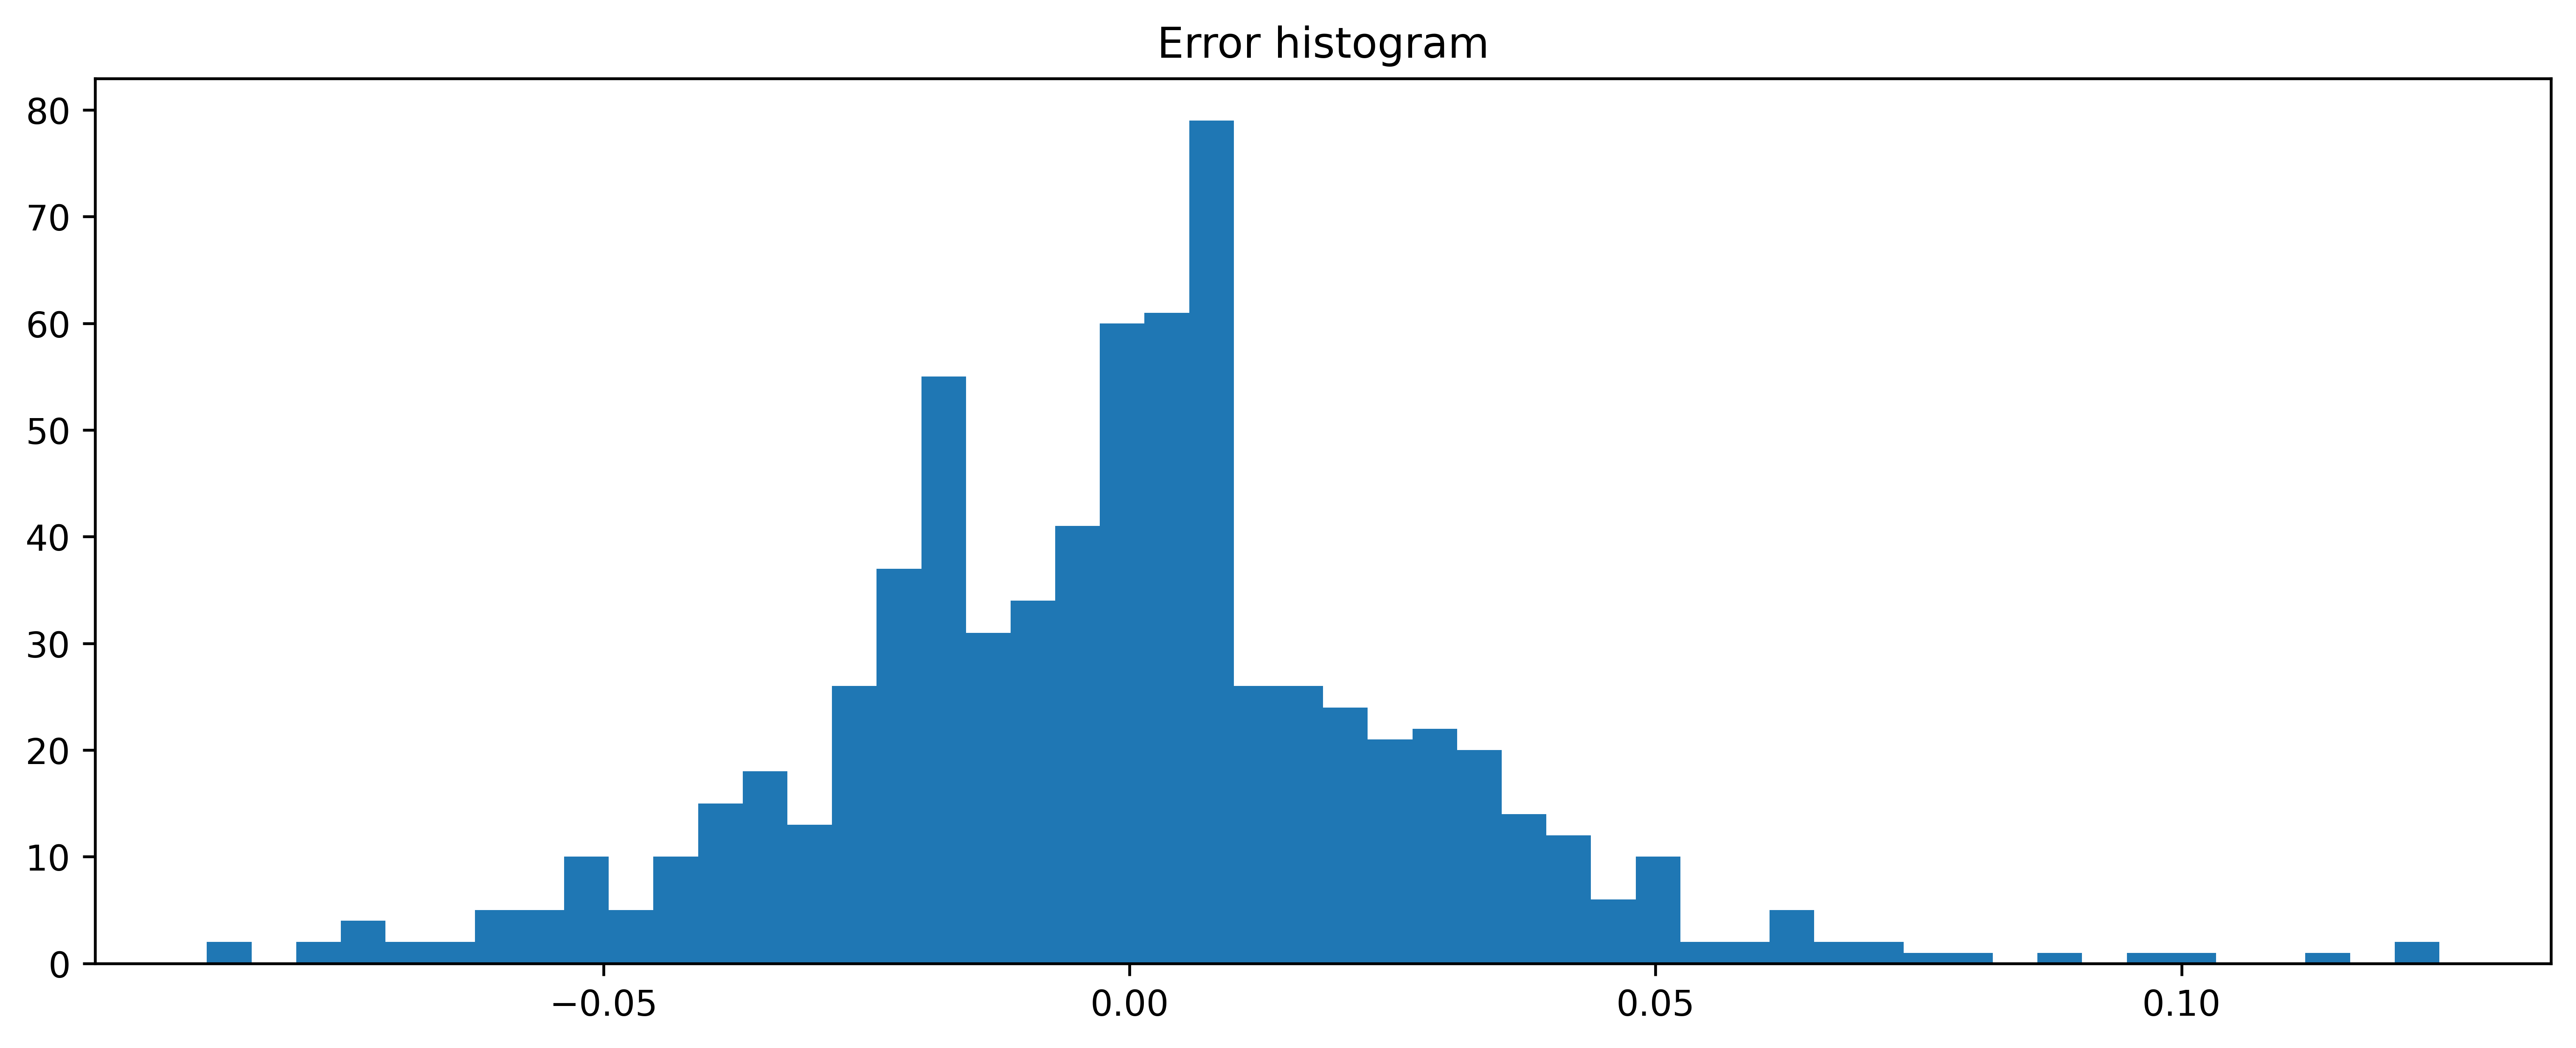

In-sample RMSE
0.028060978889761855
RC parameters
tau:159.5140796287396
C:105844.29158111523
R:0.0015070636049039432
g:15.564667718910728


In [8]:
#%% Load measurement data from 2017
data_17 = pd.read_csv(f'{data_path}\\10mins_solpap_2017.csv', index_col = 0)
data_17.index = pd.to_datetime(data_17.index, format="%d/%m/%Y %H:%M")

# Fill missing data with linear interpolation
data_17 = data_17.interpolate('linear')
assert(data_17.isna().all().sum() == 0)

# Lead T_in values (target variable)
data_17['T_Average_lead_1'] = data_17['T_Average (degC)'].shift(-1)
data_17['T_diff'] = data_17['T_External (degC)'] - data_17['T_Average (degC)']

# Drop NaNs created from the shift operator
data_17 = data_17.dropna()

# Set discretization step to 10 minutes
dt_h = 1/6

# Fill missing data with linear interpolation
data_17 = data_17.interpolate('linear')
assert(data_17.isna().all().sum() == 0)

# Visualization 
fig, ax = plt.subplots(figsize=(10,8), nrows = 3, sharex = True)

data_17['P_tot (W)'].plot(ax=ax[0])
data_17[['T_External (degC)', 'T_Average (degC)', 'T_Thermostat (degC)', 'T_Bed1 (degC)', 'T_Living (degC)']].plot(ax=ax[1])
data_17['Solar (W/m2)'].plot(ax = ax[2])
plt.show()

#%% Find parameters for lumped RC model

Y = data_17['T_Average_lead_1']
X = data_17[['T_diff', 'P_tot (W)', 'Solar (W/m2)', 'T_Average (degC)']]

# Solve a least-squares optimization problem to estimate RC parameters
A = X.values
b = Y.values

lsq_solution = lsq_linear(A, b, bounds = ([-np.inf, -np.inf, -np.inf, 1-1e-5], [np.inf, np.inf, np.inf, 1]) )

x_coeff = lsq_solution.x

alpha_1 = x_coeff[0]
alpha_2 = x_coeff[1]
alpha_3 = x_coeff[2]

tau = dt_h/alpha_1
C = dt_h/alpha_2
R = tau/C
g = alpha_3/alpha_2

T_fitted = x_coeff@A.T
fit_errors = b - x_coeff@A.T


plt.plot(b[:200], label = 'Actual')
plt.plot(x_coeff@A[:200].T, label = 'Fitted')
plt.legend()
plt.show()

plt.hist(fit_errors, bins = 50, label = 'Errors')
plt.title('Error histogram')
plt.show()

print('In-sample RMSE')
print( np.sqrt(np.square(b - x_coeff@A.T).mean()) )

print('RC parameters')
print(f'tau:{tau}')
print(f'C:{C}')
print(f'R:{R}')
print(f'g:{g}')